In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import math
import requests
import urllib.request
from bs4 import BeautifulSoup
import bleach
import re
import matplotlib.pyplot as plt
%matplotlib inline
from fa2 import ForceAtlas2
import pickle

## Data Extraction

There are two tables listing main characters in wikipedia page. We will conduct network analysis on these charactors.

Source : https://en.wikipedia.org/wiki/List_of_Game_of_Thrones_characters.

In [128]:
table1=pd.read_csv("table-1.csv")
table2=pd.read_csv("table-2.csv")

In [129]:
list1=table1.Character.tolist()[1:]
list2=table2.Character.tolist()[1:]
list_full=list1 + list2
list_full

['Eddard Stark',
 'Robert Baratheon',
 'Jaime Lannister',
 'Catelyn Stark',
 'Cersei Lannister',
 'Daenerys Targaryen',
 'Jorah Mormont',
 'Viserys Targaryen',
 'Jon Snow',
 'Sansa Stark',
 'Arya Stark',
 'Robb Stark',
 'Theon Greyjoy',
 'Bran Stark',
 'Joffrey Baratheon',
 'Sandor Clegane',
 'Tyrion Lannister',
 'Khal Drogo',
 'Petyr Baelish',
 'Davos Seaworth',
 'Samwell Tarly',
 'Stannis Baratheon',
 'Melisandre',
 'Jeor Mormont',
 'Bronn',
 'Varys',
 'Shae',
 'Margaery Tyrell',
 'Tywin Lannister',
 'Talisa Maegyr',
 'Ygritte',
 'Gendry',
 'Tormund Giantsbane',
 'Brienne of Tarth',
 'Ramsay Bolton',
 'Gilly',
 'Daario Naharis',
 'Missandei',
 'Ellaria Sand',
 'Tommen Baratheon',
 "Jaqen H'ghar",
 'Roose Bolton',
 'The High Sparrow',
 'Grey Worm',
 'Grand Maester Pycelle',
 'Meryn Trant',
 'Hodor',
 'Grenn',
 'Osha',
 'Rickon Stark',
 'Ros',
 'Gregor Clegane',
 'Janos Slynt',
 'Lancel Lannister',
 'Myrcella Baratheon',
 'Rodrik Cassel',
 'Maester Luwin',
 'Irri',
 'Doreah',
 'Renly B

**We will use web scraping to extract data**

In [130]:
def getText():
    
    pages_dic={}
    
    for character in list_full:
    
        # parse url character name
        if " " in character:
            character = re.sub(r" ", "_", character)

        url="https://gameofthrones.fandom.com/wiki/" + character # get base url

        response = requests.get(url) # request a server response

        # not found
        if response.status_code == 404:
            print("{} wiki is not found.".format(character))
            continue

        soup = BeautifulSoup(response.text, "html.parser") # parse text from html

        para=soup.findAll('p') # find all paragraphs

        # clean the raw text
        res=[]
        for p in para:
            p = re.sub(r"<.+?>", "", str(p)) # remove all other tags e.g. <a href>
            p = re.sub(r"\[\d+?\]", " ", p)  # remove footnote label e.g. [1], [2]
            p = re.sub(r"\n", "", p)         # remove the nextline character
            p = re.sub(r"\xa0", u" ", p)     # remove empty space due to encoding

            if len(p) != 0 and p[-1] == " ": # remove empty space at the end, if present
                p = p[:-1]
            res.append(p)

        page="".join(res)
        
        pages_dic[character] = page
    
    # save the file
    pickle.dump(pages_dic, open('pages.p', 'wb'))
    return None

In [62]:
# only run once
# getText()

The_High_Sparrow wiki is not found.
Grand_Maester_Pycelle wiki is not found.
Maester_Wolkan wiki is not found.
Khal_Moro wiki is not found.
Archmaester_Ebrose wiki is not found.


In [2]:
infile = open("pages.p",'rb')
pages = pickle.load(infile)
infile.close()

In [3]:
pages.keys()

dict_keys(['Eddard_Stark', 'Robert_Baratheon', 'Jaime_Lannister', 'Catelyn_Stark', 'Cersei_Lannister', 'Daenerys_Targaryen', 'Jorah_Mormont', 'Viserys_Targaryen', 'Jon_Snow', 'Sansa_Stark', 'Arya_Stark', 'Robb_Stark', 'Theon_Greyjoy', 'Bran_Stark', 'Joffrey_Baratheon', 'Sandor_Clegane', 'Tyrion_Lannister', 'Khal_Drogo', 'Petyr_Baelish', 'Davos_Seaworth', 'Samwell_Tarly', 'Stannis_Baratheon', 'Melisandre', 'Jeor_Mormont', 'Bronn', 'Varys', 'Shae', 'Margaery_Tyrell', 'Tywin_Lannister', 'Talisa_Maegyr', 'Ygritte', 'Gendry', 'Tormund_Giantsbane', 'Brienne_of_Tarth', 'Ramsay_Bolton', 'Gilly', 'Daario_Naharis', 'Missandei', 'Ellaria_Sand', 'Tommen_Baratheon', "Jaqen_H'ghar", 'Roose_Bolton', 'Grey_Worm', 'Meryn_Trant', 'Hodor', 'Grenn', 'Osha', 'Rickon_Stark', 'Ros', 'Gregor_Clegane', 'Janos_Slynt', 'Lancel_Lannister', 'Myrcella_Baratheon', 'Rodrik_Cassel', 'Maester_Luwin', 'Irri', 'Doreah', 'Renly_Baratheon', 'Yoren', 'Kevan_Lannister', 'Rakharo', 'Ilyn_Payne', 'Barristan_Selmy', 'Rast', 'Ma

In [4]:
len(pages)

154

> Build a network of main charactors.

* Node is charactor name
* Edge is their connection identified in wiki page

However, each character may have many nicknames/alias. In order to achieve higher accuracy, we find out all possible nicknames/alias (tried my best and it is tedious). We build a dictionary with key = Full Name and value = list of nicknames. We only consider nicknames for characters who are featured in https://gameofthrones.fandom.com/wiki/Game_of_Thrones_Wiki.

In [162]:
def characterDic():
    nicknames={}
    
    for name in pages.keys():
        parsed_name = name.replace("_", " ")
        

        
        nicknames[parsed_name] = [parsed_name,]
        
#         if parsed_name == "Margaery Tyrell":
#             print("{} is my FAVORITE female charactor!".format(parsed_name))
        
        # a special case of The, since The Waif is not important, we omit        
        if parsed_name == "The Waif":
            continue       
        
        # general case
        if " " in parsed_name: # both first name and last name are present
            firstname = parsed_name.split(" ")[0]
            nicknames[parsed_name] += [firstname,]
#         else: # only first name is present
#             nicknames[parsed_name] = [parsed_name,]
    
    # Some manual editing to improve accuracy
    nicknames["Jon Snow"] += ["Aegon Targaryen", "Aegon", "Lord Snow"]
    nicknames["Sansa Stark"] += ["Sansa",]
    nicknames["Arya Stark"] += ["Arya",]
    nicknames["Bran Stark"] += ["Three-Eyed Raven", "Bran", "Brandon"]
    nicknames["Edmure Tully"] += ["Edmure", ]
    nicknames["Davos Seaworth"] += ["The Onion Knight", "Ser Onion Knight", "Davos"]
    nicknames["Tormund"] = ["Tormund", "Tormund Giantsbane",]
    nicknames["Meera Reed"] += ["Meera", ]
    nicknames["Lyanna Mormont"] += ["Lyanna", ]
    nicknames["Benjen Stark"] += ["Benjen",]
    nicknames["Cersei Lannister"] += ["Cersei", ]
    nicknames["Jaime Lannister"] += ["Jaime", "Kingslayer"]
    nicknames["Tyrion Lannister"] += ["Imp", "Halfman", "Little Lion"]
    nicknames["Qyburn"] += ["Qyburn",]
    nicknames["Gregor Clegane"] += ["The Mountain", "Gregor"]
    nicknames["Bronn"] += ["Bronn",]
    nicknames["Tywin Lannister"] += ["Tywin",]
    nicknames["Joffrey Baratheon"] += ["Joffrey", "Joff"]
    nicknames["Myrcella Baratheon"] += ["Myrcella",]
    nicknames["Tommen Baratheon"] += ["Tommen",]
    nicknames["Daenerys Targaryen"] += ["Daenerys Stormborn", "Stormborn", "Dany", 
                                       "Mhysa", "Dragon Queen", "Khaleesi"]
    nicknames["Rhaegar Targaryen"] = ["Rhaegar Targaryen", "Rhaegar"]
    nicknames["Varys"] += ["Spider", "Eunuch"]
    nicknames["Yara Greyjoy"] += ["Yara",]
    nicknames["Theon Greyjoy"] += ['Theon', "Reek"]
    nicknames["Missandei"] += ["Missandei",]
    nicknames["Grey Worm"] += ["Torgo Nudho",]
    nicknames["Olenna Tyrell"] += ["Redwyne", "Olenna"]
    nicknames["Ellaria Sand"] += ["Ellaria",]
    nicknames["Brienne of Tarth"] += ["Brienne", "Maid of Tarth"]
    nicknames["Podrick Payne"] += ["Podrick",]
    nicknames["Samwell Tarly"] += ["Sam", "Samwell", "Piggy"]
    nicknames["Gilly"] += ["Gilly",]
    nicknames["Gendry Baratheon"] = ["Gendry Baratheon", "Gendry", "Clovis"]
    nicknames["Petyr Baelish"] += ["Littlefinger", "Petyr", "Baelish"]
    print("Yeah, my FAVORITE male character Sandor Clegane!")
    nicknames["Sandor Clegane"] += ["Hound", "Sandor"]
    nicknames["Melisandre"] += ["Red Woman", "Red Witch"]
    nicknames["Euron Greyjoy"] += ["Euron", ]
    nicknames["Night King"] += ["Night King",]
    
    return nicknames

In [163]:
characters=characterDic()

Yeah, my FAVORITE male character Sandor Clegane!


In [164]:
characters["The Waif"]

['The Waif']

In [165]:
"The Waif" in list(characters.keys())

True

In [166]:
def edgeWeight(pagesDic, namesDic):
    # key = (A,B), value = N
    # In wiki page of A, B is mentioned N times
    res_dic={}
    
    # loop through each character
    for name in namesDic:
        
        # obtain all his names/alias
        nameList=[name,] + namesDic[name]
        
        # loop through every wikipages
        for character in pagesDic:
            parsed_character = character.replace("_", " ")
            
            # prevent self loop --> Jon Snow page mentions Jon Snow himself N times
            if parsed_character != name:
                count=0
                # obtain the text
                text=pagesDic[character]
                
                # count for every mention of alias
                for alias in nameList:
                    count += text.count(alias)
                    
                # update result dictionary
                if count != 0:
                    res_dic[(parsed_character, name)]=count

    return res_dic

In [167]:
edgeWightDic=edgeWeight(pages,characters)

In [168]:
G.clear()
G=nx.DiGraph()
G.add_nodes_from(characters.keys())
G.add_edges_from([(k[0],k[1],{"weight" : v}) for (k,v) in edgeWightDic.items()])

In [169]:
G["The Waif"]

AtlasView({'Arya Stark': {'weight': 196}, 'Sandor Clegane': {'weight': 1}, "Jaqen H'ghar": {'weight': 28}, 'Meryn Trant': {'weight': 3}, 'Syrio Forel': {'weight': 3}, 'Black Lorren': {'weight': 7}, 'Black Walder Rivers': {'weight': 7}, 'Lady Crane': {'weight': 16}})

In [157]:
characters.keys()

dict_keys(['Eddard Stark', 'Robert Baratheon', 'Jaime Lannister', 'Catelyn Stark', 'Cersei Lannister', 'Daenerys Targaryen', 'Jorah Mormont', 'Viserys Targaryen', 'Jon Snow', 'Sansa Stark', 'Arya Stark', 'Robb Stark', 'Theon Greyjoy', 'Bran Stark', 'Joffrey Baratheon', 'Sandor Clegane', 'Tyrion Lannister', 'Khal Drogo', 'Petyr Baelish', 'Davos Seaworth', 'Samwell Tarly', 'Stannis Baratheon', 'Melisandre', 'Jeor Mormont', 'Bronn', 'Varys', 'Shae', 'Margaery Tyrell', 'Tywin Lannister', 'Talisa Maegyr', 'Ygritte', 'Gendry', 'Tormund Giantsbane', 'Brienne of Tarth', 'Ramsay Bolton', 'Gilly', 'Daario Naharis', 'Missandei', 'Ellaria Sand', 'Tommen Baratheon', "Jaqen H'ghar", 'Roose Bolton', 'Grey Worm', 'Meryn Trant', 'Hodor', 'Grenn', 'Osha', 'Rickon Stark', 'Ros', 'Gregor Clegane', 'Janos Slynt', 'Lancel Lannister', 'Myrcella Baratheon', 'Rodrik Cassel', 'Maester Luwin', 'Irri', 'Doreah', 'Renly Baratheon', 'Yoren', 'Kevan Lannister', 'Rakharo', 'Ilyn Payne', 'Barristan Selmy', 'Rast', 'Ma

In [120]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=0.0001,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.08,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.001,
                        strongGravityMode=False,
                        gravity=0,

                        # Log
                        verbose=False)
positions = forceatlas2.forceatlas2_networkx_layout(G.to_undirected(), 
                                                    pos=None,iterations=1000)

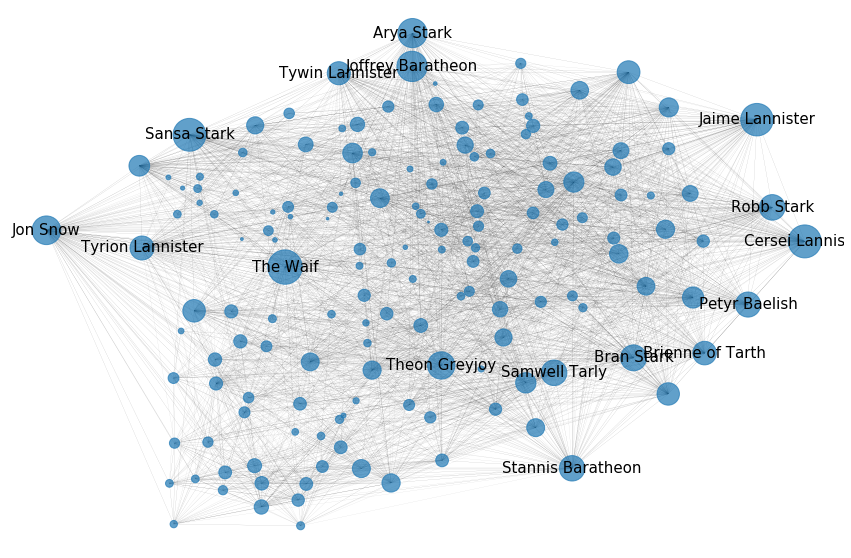

In [121]:
labeling={}
for node in G.nodes:
    if G.degree(weight="weight")[node] > 1500:
        labeling[node] = node
nodeSize=[G.degree(weight="weight")[character] for character in G.nodes]      

plt.figure(figsize=(15,10))
plt.axis("off")
nx.draw_networkx_edges(G, positions, width = 0.1, alpha = 0.3, arrows=False)
nx.draw_networkx_nodes(G, positions,alpha= 0.7, 
                       node_size=[size/sum(nodeSize) * 100000/3 for size in nodeSize])
nx.draw_networkx_labels(G, positions, labels=labeling, font_size=15)
plt.show()

Some helper function before giving our awards.

In [50]:
def getColorList(champion, first_runner_up, second_runner_up):
    colorList=[]
    for node in G.nodes:
        if node == champion:
            colorList.append("#ffd700") # gold
        elif node == first_runner_up:
            colorList.append("#aaa9ad") # silver
        elif node == second_runner_up:
            colorList.append("#cd7f32") # bronze
        else:
            colorList.append("#0000ff")
    return colorList

In [52]:
def getLabeling(sortedList, topN):
    labeling={}
    for node in G.nodes:
        if node in list(map(lambda x : x[0], sortedList[:topN])):
            labeling[node] = node
    return labeling

In [81]:
def plot(sizes,colors,labeling, adjustFactor):
    plt.figure(figsize=(15,10))
    plt.axis("off")
    nx.draw_networkx_edges(G, positions, width = 0.1, alpha = 0.3, arrows=False)
    nx.draw_networkx_nodes(G, positions,alpha= 0.7, node_color=colors,
                           node_size=[size * adjustFactor for size in sizes])
    nx.draw_networkx_labels(G, positions, labels=labeling, font_size=12)
    plt.show()
    return 

## Most Mentioned Award

Who is mentioned the most number of times in others' wiki page?

In [82]:
sorting=sorted(list(G.in_degree(weight="weight")), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('The Waif', 3225), ('Joffrey Baratheon', 2040), ('Cersei Lannister', 1817)]

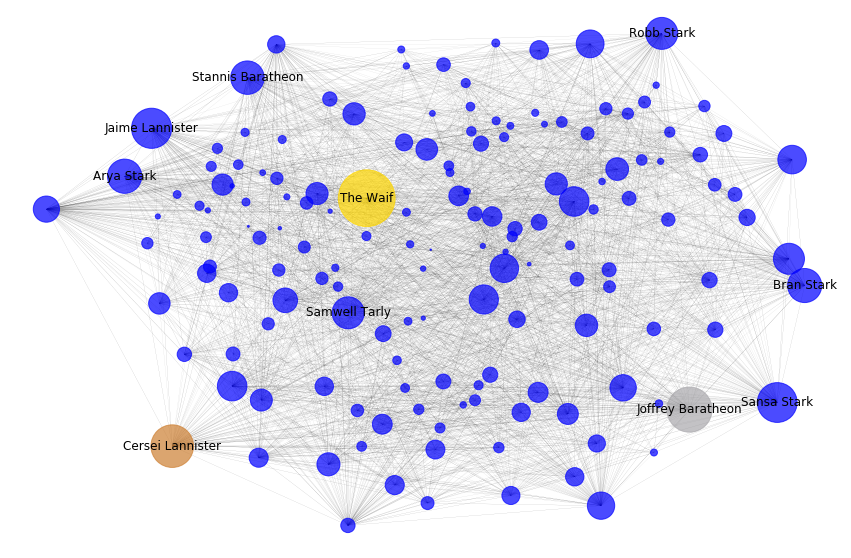

In [83]:
plot([G.in_degree(weight="weight")[character] for character in G.nodes],
     getColorList('The Waif','Joffrey Baratheon','Cersei Lannister'),
     getLabeling(sorting, 10),1)

## The most mentioned award goes to........The Waif!

## Most Social Award

Whose page mentioned the most number of other characters?

In [84]:
sorting=sorted(list(G.out_degree(weight="weight")), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Jon Snow', 1663), ('Sansa Stark', 1495), ('Tyrion Lannister', 1438)]

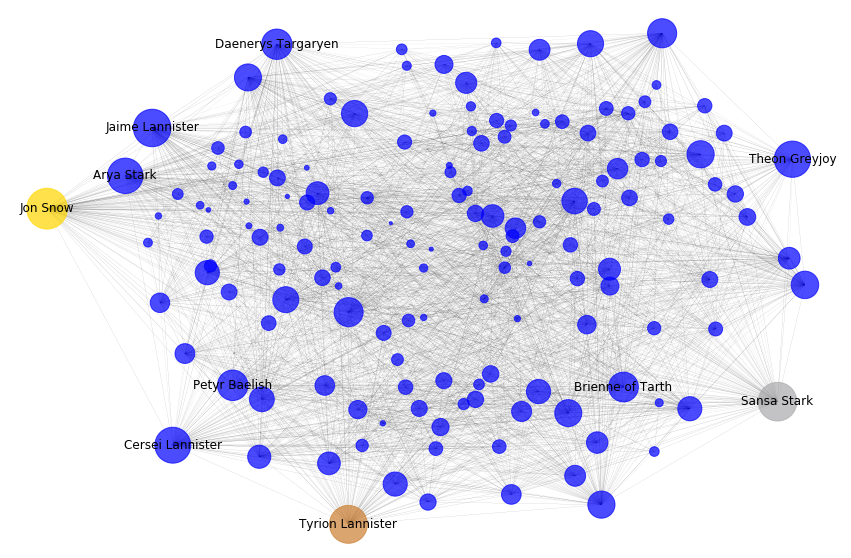

In [85]:
plot([G.out_degree(weight="weight")[character] for character in G.nodes],
     getColorList('Jon Snow','Sansa Stark','Tyrion Lannister'),
     getLabeling(sorting, 10),1)

## The most social award goes to........Jon Snow!

In [100]:
G['The Waif']

AtlasView({'Arya Stark': {'weight': 98}, 'Sandor Clegane': {'weight': 1}, "Jaqen H'ghar": {'weight': 25}, 'Meryn Trant': {'weight': 2}, 'Syrio Forel': {'weight': 2}, 'Black Lorren': {'weight': 7}, 'Black Walder Rivers': {'weight': 7}, 'Lady Crane': {'weight': 11}})

## Most "Closeness" Award

Who is on average closest other characters?

In [95]:
sorting=sorted(list(nx.closeness_centrality(G).items()), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('The Waif', 0.9681141439205955),
 ('Jon Snow', 0.739200454717696),
 ('Black Lorren', 0.7179793890320206)]

In [99]:
nx.closeness_centrality(G)

{'Eddard Stark': 0.6440244305051172,
 'Robert Baratheon': 0.6581477732793521,
 'Jaime Lannister': 0.6639720898570456,
 'Catelyn Stark': 0.5838820712361568,
 'Cersei Lannister': 0.6729044498102794,
 'Daenerys Targaryen': 0.6610471026770586,
 'Jorah Mormont': 0.5496618765849535,
 'Viserys Targaryen': 0.5156621728786677,
 'Jon Snow': 0.739200454717696,
 'Sansa Stark': 0.6610471026770586,
 'Arya Stark': 0.6610471026770586,
 'Robb Stark': 0.6639720898570456,
 'Theon Greyjoy': 0.5884615384615384,
 'Bran Stark': 0.638543371522095,
 'Joffrey Baratheon': 0.6304945054945055,
 'Sandor Clegane': 0.5749336870026525,
 'Tyrion Lannister': 0.6581477732793521,
 'Khal Drogo': 0.4872002997002997,
 'Petyr Baelish': 0.586162860576923,
 'Davos Seaworth': 0.5884615384615384,
 'Samwell Tarly': 0.5978394115844315,
 'Stannis Baratheon': 0.6524247491638796,
 'Melisandre': 0.5620138288677614,
 'Jeor Mormont': 0.5228491021173948,
 'Bronn': 0.5771449704142012,
 'Varys': 0.586162860576923,
 'Shae': 0.485623599701269

In [96]:
sorting[:5]

[('The Waif', 0.9681141439205955),
 ('Jon Snow', 0.739200454717696),
 ('Black Lorren', 0.7179793890320206),
 ('Black Walder Rivers', 0.7179793890320206),
 ('Cersei Lannister', 0.6729044498102794)]

In [97]:
getLabeling(sorting, 10)

{'Jaime Lannister': 'Jaime Lannister',
 'Cersei Lannister': 'Cersei Lannister',
 'Daenerys Targaryen': 'Daenerys Targaryen',
 'Jon Snow': 'Jon Snow',
 'Sansa Stark': 'Sansa Stark',
 'Arya Stark': 'Arya Stark',
 'Robb Stark': 'Robb Stark',
 'Black Lorren': 'Black Lorren',
 'Black Walder Rivers': 'Black Walder Rivers',
 'The Waif': 'The Waif'}

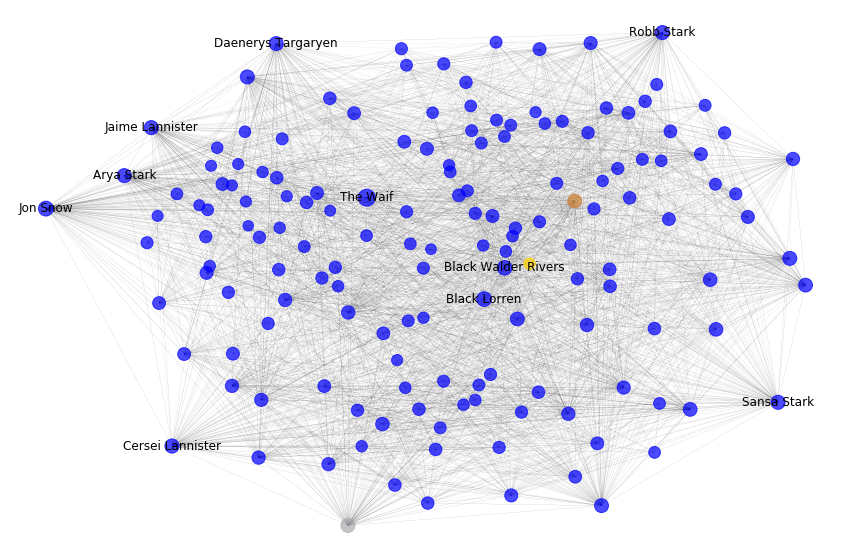

In [98]:
plot(list(nx.closeness_centrality(G).values()),
     getColorList('Izembaro','Tyrion Lannister','Tywin Lannister'),
     getLabeling(sorting, 10), 300)

## The most social award goes to........Jon Snow!

In [72]:
sorting=sorted(list(nx.closeness_centrality(G)), key=lambda x : x[1], reverse=True)
sorting

['Izembaro',
 'Tyrion Lannister',
 'Tywin Lannister',
 'Myrcella Baratheon',
 'Pypar',
 'Lysa Arryn',
 'Syrio Forel',
 'Pyat Pree',
 'Qyburn',
 'Myranda',
 'Tyene Sand',
 'Nymeria Sand',
 'Lyanna Mormont',
 'Wun Weg Wun Dar Wun',
 'Euron Greyjoy',
 'Stannis Baratheon',
 'Othell Yarwyck',
 'Styr',
 'Osha',
 'Arya Stark',
 'Bran Stark',
 'Bronn',
 'Brienne of Tarth',
 'Grey Worm',
 'Grenn',
 'Gregor Clegane',
 'Irri',
 'Greatjon Umber',
 'Craster',
 'Brynden Tully',
 'Orell',
 'Kraznys mo Nakloz',
 'Areo Hotah',
 'Trystane Martell',
 'Spice King',
 'Robert Baratheon',
 'Jorah Mormont',
 'Jon Snow',
 'Robb Stark',
 'Joffrey Baratheon',
 'Tormund Giantsbane',
 'Tommen Baratheon',
 'Roose Bolton',
 'Hodor',
 'Ros',
 'Rodrik Cassel',
 'Doreah',
 'Yoren',
 'Robin Arryn',
 'Qotho',
 'Jory Cassel',
 'Loras Tyrell',
 'Hot Pie',
 'Rorge',
 'Lommy Greenhands',
 'Podrick Payne',
 'Dontos Hollard',
 'Kovarro',
 'Jojen Reed',
 'Locke',
 'Lothar Frey',
 'Yohn Royce',
 'Bowen Marsh',
 'Doran Martell',
